### Прогнозирование стоимости автомобиля

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [10]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [11]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [12]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


### Предобработка

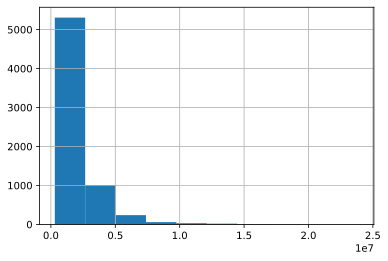

In [13]:
train.price.hist()

In [14]:
# Так как большой разбег по стоимости, то построим зависимость от логарифма цены
train['log_price'] = np.log(train.price)
#test['log_price'] = np.log(test.price)

In [15]:
train.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
log_price                  0
dtype: int64

Пропущенные значение во Владении(4326) и Владельцы(1)

In [16]:
train.Владельцы.value_counts()

3 или более    2646
1 владелец     2029
2 владельца    2006
Name: Владельцы, dtype: int64

In [17]:
train[train.Владельцы.isna()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,log_price
4994,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,4.2 LTR,360 N12,бензин,160000,1999,S8,...,2001,1019330519,SEDAN AUTOMATIC 4.2,автоматическая,NaN,10 лет и 7 месяцев,Оригинал,полный,Левый,13.304685


In [18]:
#Заполним пунктом 3 и более
train['Владельцы'] = train['Владельцы'].fillna('3')

In [19]:
train.Владельцы = train.Владельцы.apply(lambda x: x[0])
test.Владельцы = test.Владельцы.apply(lambda x: x[0])

In [20]:
train.Владельцы = train.Владельцы.values.astype('int64')
test.Владельцы = test.Владельцы.values.astype('int64')

In [21]:
# Пропущенных значений
train.Владение.isna().sum()

4326

In [22]:
train.groupby('Владельцы').Владение.describe()

,count,unique,top,freq
Владельцы,,,,
1,705,147,1 год и 8 месяцев,18
2,742,144,1 год,18
3,909,134,2 года и 2 месяца,23


In [23]:
train.groupby('modelDate').Владение.describe()

,count,unique,top,freq
modelDate,,,,
1975,0,0,NaN,NaN
1976,0,0,NaN,NaN
1977,1,1,6 лет и 3 месяца,1
1979,0,0,NaN,NaN
1981,2,2,1 год и 6 месяцев,1
1982,4,4,5 лет и 9 месяцев,1
1984,1,1,7 месяцев,1
1985,1,1,15 лет и 3 месяца,1
1986,1,1,15 лет и 10 месяцев,1


Много пропущенных значений и люди редко долго владеют машинами. Удалим этот признак - как не возлагающий надежды - но требующий разработки какой-то медики по заполнению пропущенных значений

In [24]:
# Посмотрим есть ли дубликаты
train.duplicated().value_counts()

False    6682
dtype: int64

In [25]:
# Посмотрим на заполнение признака мощность двигателя
train.enginePower

0       272 N12
1       204 N12
2       306 N12
3       180 N12
4       160 N12
         ...   
6677    150 N12
6678    190 N12
6679    143 N12
6680    310 N12
6681    394 N12
Name: enginePower, Length: 6682, dtype: object

In [26]:
#Приведем ее к числову формату
train['enginePower'] = train['enginePower'].apply(lambda x: x.replace(' N12', ''))
test['enginePower'] = test['enginePower'].apply(lambda x: x.replace(' N12', ''))

train['enginePower'] = train['enginePower'].values.astype('int64')
test['enginePower'] = test['enginePower'].values.astype('int64')

In [27]:
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: x[:3])
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: x[:3])

In [28]:
train['engineDisplacement'].value_counts()

2.0    1929
3.0    1862
1.8     329
1.6     327
4.4     260
5.5     227
3.5     208
2.5     203
2.1     181
4.0     121
4.7     109
2.8      89
1.4      82
4.2      80
1.5      61
5.0      60
3.2      49
2.2      44
2.9      43
4.8      41
3.1      39
2.4      38
6.2      31
1.3      30
6.0      30
5.4      27
1.2      26
2.7      22
4.1      19
3.6      18
1.7      11
3.7      11
5.9      10
5.2      10
2.6       7
2.3       5
4.6       5
0.7       5
und       5
3.4       4
1.9       4
6.6       4
6.3       3
4.3       3
5.8       3
5.6       3
4.9       2
3.8       2
Name: engineDisplacement, dtype: int64

In [29]:
# имеется значение 'und', заменим его
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: 2.0 if x == 'und' else x)
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: 2.0 if x == 'und' else x)

In [30]:
# Приведем к числовому формату
train['engineDisplacement'] = train['engineDisplacement'].values.astype('float32')
test['engineDisplacement'] = test['engineDisplacement'].values.astype('float32')

# EDA

### 1. BodyType

In [31]:
train.bodyType.value_counts()

седан                   2843
внедорожник 5 дв.       2315
купе                     427
хэтчбек 5 дв.            296
лифтбек                  245
универсал 5 дв.          153
минивэн                  146
купе-хардтоп              91
родстер                   60
кабриолет                 44
хэтчбек 3 дв.             41
компактвэн                 8
лимузин                    5
внедорожник 3 дв.          3
внедорожник открытый       2
пикап двойная кабина       2
седан 2 дв.                1
Name: bodyType, dtype: int64

In [32]:
train['bodyType2'] = train.bodyType
bodyType = train.bodyType2.value_counts()[:5]
bodyType

седан                2843
внедорожник 5 дв.    2315
купе                  427
хэтчбек 5 дв.         296
лифтбек               245
Name: bodyType2, dtype: int64

In [33]:
test['bodyType2'] = test.bodyType

In [34]:
# Выделим 5 основных, остальные заменим общим типом "другой"
train['bodyType2'] = train['bodyType2'].apply(lambda x: x if x in bodyType else 'другой')
test['bodyType2'] = test['bodyType2'].apply(lambda x: x if x in bodyType else 'другой')

In [35]:
# Проверим
test['bodyType2'].value_counts()

седан                698
внедорожник 5 дв.    581
другой               154
купе                 116
хэтчбек 5 дв.         68
лифтбек               54
Name: bodyType2, dtype: int64

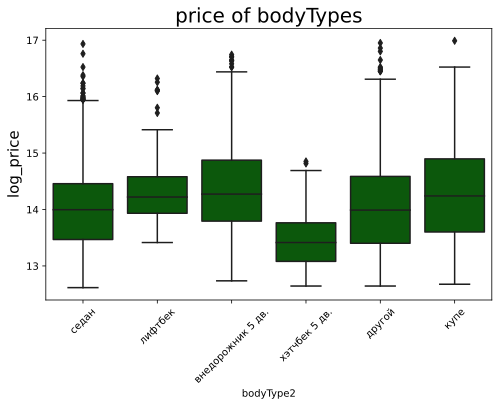

In [36]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='bodyType2', 
                  data=train, color='darkgreen')
g1.set_title("price of bodyTypes", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [37]:
#добавим столбец
train = train.assign(bT_length = train['bodyType'].apply(len))
test = test.assign(bT_length = test['bodyType'].apply(len))

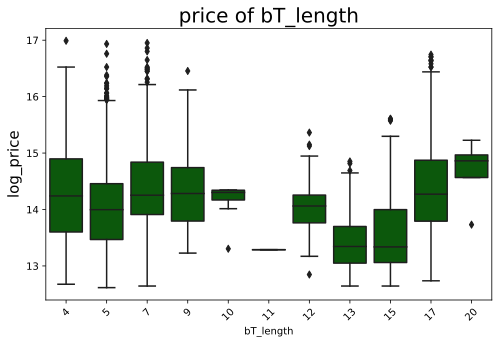

In [38]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='bT_length', 
                  data=train, color='darkgreen')
g1.set_title("price of bT_length", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Очевидно что стоимость зависит от типа кузова

## 2. brand

In [39]:
len(train.brand.value_counts())

3

In [40]:
train.groupby('brand').price.describe()

,count,mean,std,min,25%,50%,75%,max
brand,,,,,,,,
AUDI,1583.0,1.234282e+06,9.417145e+05,308999.0,640000.0,950000.0,1498500.0,6999000.0
BMW,2805.0,1.718738e+06,1.456983e+06,301301.0,800000.0,1285000.0,2187000.0,14000000.0
MERCEDES,2294.0,2.580642e+06,2.580354e+06,310000.0,1050000.0,1740000.0,3150000.0,23900000.0


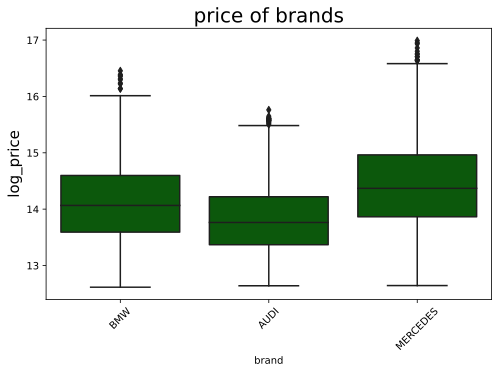

In [41]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='brand', 
                  data=train, color='darkgreen')
g1.set_title("price of brands", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

## 3. color

In [42]:
display(pd.DataFrame(train.color.value_counts()))

,color
чёрный,2805
белый,1263
серый,733
синий,685
серебристый,341
коричневый,307
красный,203
бежевый,76
голубой,72
зелёный,70


In [43]:
train['color2'] = train.color
test['color2'] = test.color
color = train.color2.value_counts()[:5]
color

чёрный         2805
белый          1263
серый           733
синий           685
серебристый     341
Name: color2, dtype: int64

In [44]:
train['color2'] = train['color2'].apply(lambda x: x if x in color else 'другой')
test['color2'] = test['color2'].apply(lambda x: x if x in color else 'другой')

In [45]:
train.color2.value_counts()

чёрный         2805
белый          1263
другой          855
серый           733
синий           685
серебристый     341
Name: color2, dtype: int64

## 4. model_info

In [46]:
train.model_info.value_counts()

5ER               611
3ER               466
E_KLASSE          410
X5                397
A6                358
                 ... 
None                1
SLR_KLASSE          1
100                 1
SLC_KLASSE_AMG      1
X3_M                1
Name: model_info, Length: 118, dtype: int64

In [47]:
train.model_info.nunique()

118

In [48]:
train[train['model_info'] == 'None'].description

1132    Автомобиль в очень хорошем состоянии. Богатая ...
Name: description, dtype: object

In [49]:
train.loc[train['model_info'] == 'None', 'model_info'] = 'C_KLASSE_AMG'

## 5. name

In [50]:
test.name

0                    300 3.0 AT (220 л.с.)
1       640d xDrive 3.0d AT (313 л.с.) 4WD
2              325xi 2.5 AT (218 л.с.) 4WD
3                   318i 2.0 AT (136 л.с.)
4       520d xDrive 2.0d AT (190 л.с.) 4WD
                       ...                
1666                320i 2.0 AT (184 л.с.)
1667            25d 3.0d AT (218 л.с.) 4WD
1668                    1.4 AMT (150 л.с.)
1669                520i 2.0 AT (184 л.с.)
1670                2.0 AMT (225 л.с.) 4WD
Name: name, Length: 1671, dtype: object

Информация о мощности, приводе и объеме двигателя дублируется, поэтому удалим этот признак

## 6. enginePower

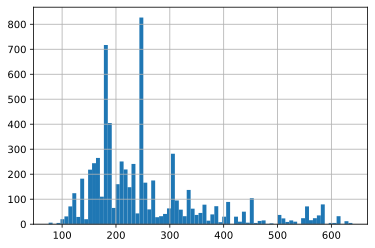

In [51]:
train['enginePower'].hist(bins=77)

In [52]:
train.enginePower.describe()

count    6682.000000
mean      255.788686
std       109.240110
min        75.000000
25%       184.000000
50%       231.000000
75%       306.000000
max       639.000000
Name: enginePower, dtype: float64

In [53]:
train['log_power'] = np.log(train.enginePower)
test['log_power'] = np.log(test.enginePower)

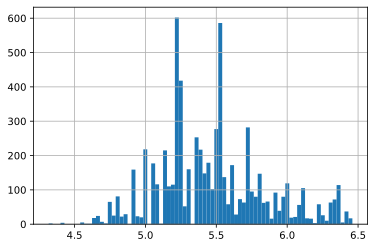

In [54]:
train['log_power'].hist(bins=77)

In [55]:
#Попробеум ввести признак соответствующий налогу в зависимости от мощности
# Разобьем возраст на интервалы
bins = [74, 100, 125, 150, 175, 200, 225, 250, 801]
numbers = ['12','25','35', '45', '50', '65', '75', '150']

In [56]:
#налоговая база
train['Nalog_base']=pd.cut(train['enginePower'],bins,labels=numbers)
test['Nalog_base']=pd.cut(test['enginePower'],bins,labels=numbers)
train['Nalog_base'] = train['Nalog_base'].values.astype('int64')
test['Nalog_base'] = test['Nalog_base'].values.astype('int64')

In [57]:
train['Nalog'] = train['enginePower'] * train['Nalog_base']
test['Nalog'] = test['enginePower'] * test['Nalog_base']

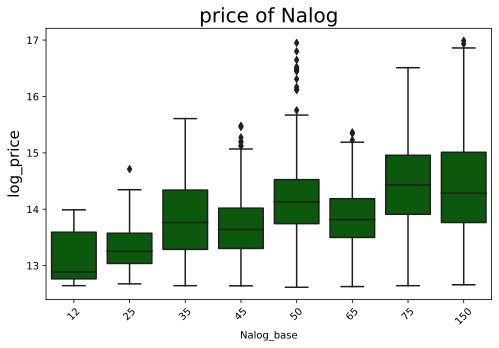

In [58]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='Nalog_base', 
                  data=train, color='darkgreen')
g1.set_title("price of Nalog", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

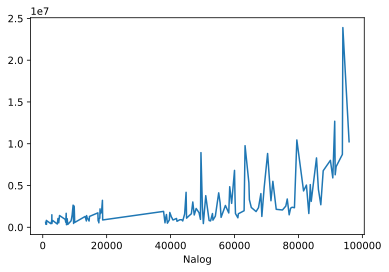

In [59]:
train.groupby('Nalog').price.mean().plot()

### 7.engineDisplacement

In [60]:
train.engineDisplacement.value_counts()

2.0    1934
3.0    1862
1.8     329
1.6     327
4.4     260
5.5     227
3.5     208
2.5     203
2.1     181
4.0     121
4.7     109
2.8      89
1.4      82
4.2      80
1.5      61
5.0      60
3.2      49
2.2      44
2.9      43
4.8      41
3.1      39
2.4      38
6.2      31
6.0      30
1.3      30
5.4      27
1.2      26
2.7      22
4.1      19
3.6      18
1.7      11
3.7      11
5.9      10
5.2      10
2.6       7
4.6       5
0.7       5
2.3       5
3.4       4
1.9       4
6.6       4
5.6       3
6.3       3
4.3       3
5.8       3
4.9       2
3.8       2
Name: engineDisplacement, dtype: int64

## 8. Руль

In [61]:
display(pd.DataFrame(train.Руль.value_counts()))

,Руль
Левый,6680
Правый,2


In [62]:
display(pd.DataFrame(test.Руль.value_counts()))

,Руль
Левый,1671


Можно удалить этот признак раз он нам в тесте принимает единственное значение

## 9.fuelType

In [63]:
display(pd.DataFrame(train.fuelType.value_counts()))

,fuelType
бензин,4804
дизель,1861
гибрид,12
электро,5


In [64]:
display(pd.DataFrame(test.fuelType.value_counts()))

,fuelType
бензин,1214
дизель,454
гибрид,2
электро,1


## 10. sell_id

In [65]:
train.sell_id.nunique()

6682

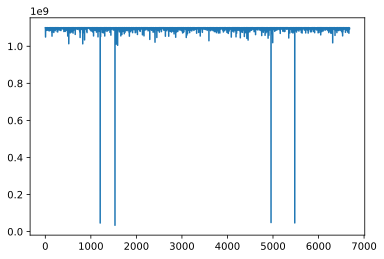

In [66]:
train['sell_id'].plot()

id объявления о продаже содержит уникальных значений сколько и объявлений. Можно удалить.

## 11. mileage

In [67]:
train.mileage.describe()

count      6682.000000
mean     120522.610895
std       81454.448294
min           1.000000
25%       59181.250000
50%      111000.000000
75%      168000.000000
max      999999.000000
Name: mileage, dtype: float64

In [68]:
train[train.mileage == 1]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,ПТС,Привод,Руль,log_price,bodyType2,bT_length,color2,log_power,Nalog_base,Nalog
503,минивэн,MERCEDES,чёрный,Безопасность: 17. Салон: 13. Мультимедиа: 10. ...,2.0,239,дизель,1,2014,V_KLASSE,...,Оригинал,полный,Левый,16.510138,другой,7,чёрный,5.476464,75,17925
687,купе,MERCEDES,чёрный,Год выпуска: 2020. Пробег: 1 км. Кузов: купе. ...,3.0,367,бензин,1,2017,S_KLASSE,...,Оригинал,полный,Левый,15.775605,купе,4,чёрный,5.905362,150,55050
1438,минивэн,MERCEDES,чёрный,В данной конфигурации мы предусмотрели для Вас...,2.1,190,дизель,1,2014,V_KLASSE,...,Оригинал,полный,Левый,16.308716,другой,7,чёрный,5.247024,50,9500
1588,минивэн,MERCEDES,серый,Объединяя современную технологию и разработку ...,2.1,190,дизель,1,2014,V_KLASSE,...,Оригинал,задний,Левый,16.118096,другой,7,серый,5.247024,50,9500
1715,внедорожник 5 дв.,MERCEDES,чёрный,Все машины Вы можете посмотреть нажав над объя...,2.9,330,дизель,1,2019,GLS_KLASSE,...,Оригинал,полный,Левый,16.341239,внедорожник 5 дв.,17,чёрный,5.799093,150,49500
3558,минивэн,MERCEDES,чёрный,В данной конфигурации мы предусмотрели для Вас...,2.1,190,дизель,1,2014,V_KLASSE,...,Оригинал,полный,Левый,16.482739,другой,7,чёрный,5.247024,50,9500
6431,минивэн,MERCEDES,чёрный,В данной конфигурации мы предусмотрели для Вас...,2.1,190,дизель,1,2014,V_KLASSE,...,Оригинал,полный,Левый,16.453853,другой,7,чёрный,5.247024,50,9500


In [69]:
#Даже у новых машин 1 км это мало. заменим на 10000
train['mileage'] = train['mileage'].apply(lambda x: 1000 if x <100 else x)
test['mileage'] = test['mileage'].apply(lambda x: 1000 if x < 100 else x)

## 12. ПТС

In [70]:
display(pd.DataFrame(test.ПТС.value_counts()))

,ПТС
Оригинал,1504
Дубликат,167


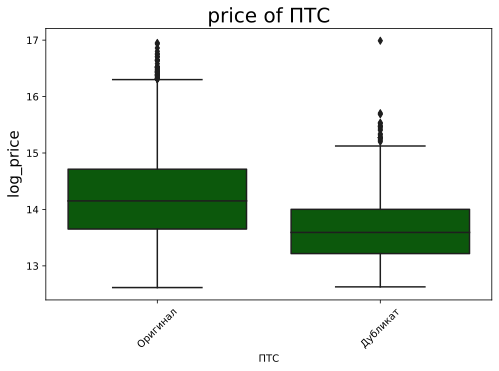

In [71]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='ПТС', 
                  data=train, color='darkgreen')
g1.set_title("price of ПТС", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Большая часть машин с оригинальным птс и стоят они дороже

## 13. numberOfDoors

In [72]:
display(pd.DataFrame(test.numberOfDoors.value_counts()))

,numberOfDoors
5,764
4,713
2,175
3,19


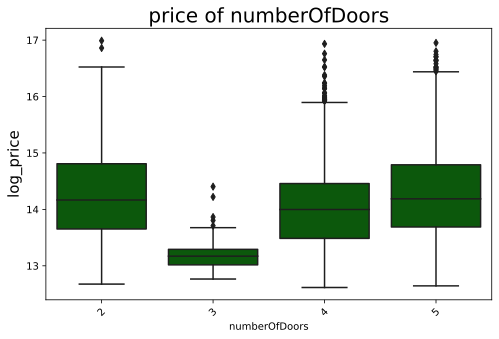

In [73]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='numberOfDoors', 
                  data=train, color='darkgreen')
g1.set_title("price of numberOfDoors", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

## 14.Привод

In [74]:
test.Привод.value_counts()

полный      1029
задний       469
передний     173
Name: Привод, dtype: int64

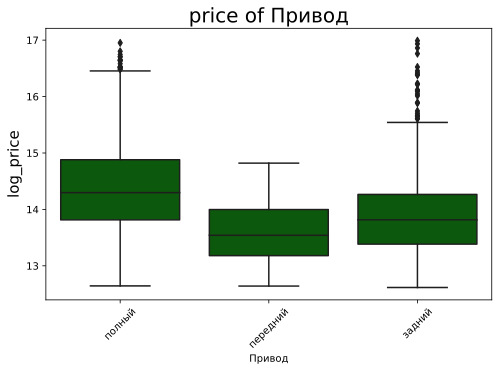

In [75]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='Привод', 
                  data=train, color='darkgreen')
g1.set_title("price of Привод", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)


plt.show()

Полный самый дорогой, а передний - самый дешевый.

## 15. modelDate

In [76]:
train.modelDate.describe()

count    6682.000000
mean     2010.135588
std         5.370973
min      1975.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: modelDate, dtype: float64

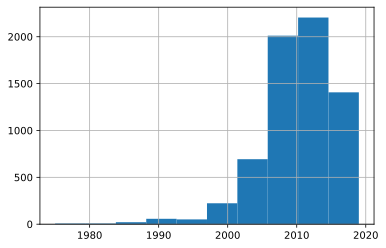

In [77]:
train['modelDate'].hist()

Основная доля машин выпущена за последние 20 лет

## 16. productionDate

In [78]:
train['years_old'] = 2021 - train['productionDate']
test['years_old'] = 2021 - test['productionDate']

In [79]:
train['years_old'].describe()

count    6682.000000
mean        8.968423
std         5.049676
min         1.000000
25%         5.000000
50%         8.000000
75%        12.000000
max        39.000000
Name: years_old, dtype: float64

In [80]:
# Разобьем возраст на интервалы
bins = [-1, 6, 13, 40]
numbers = ['6','13','40']

train['age_intervals']=pd.cut(train['years_old'],bins,labels=numbers)
test['age_intervals']=pd.cut(test['years_old'],bins,labels=numbers)

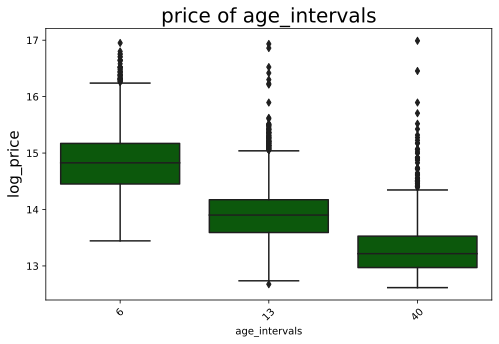

In [81]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='age_intervals', 
                  data=train, color='darkgreen')
g1.set_title("price of age_intervals", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

C увеличение возраста падает цена машины

## 17. vehicleConfiguration

In [82]:
train.vehicleConfiguration[334]

'ALLROAD_5_DOORS AUTOMATIC 3.0'

в принципе дублирует информацию. Удаляем

## 18. vehicleTransmission

In [83]:
test.vehicleTransmission.value_counts()

автоматическая      1299
роботизированная     242
вариатор              81
механическая          49
Name: vehicleTransmission, dtype: int64

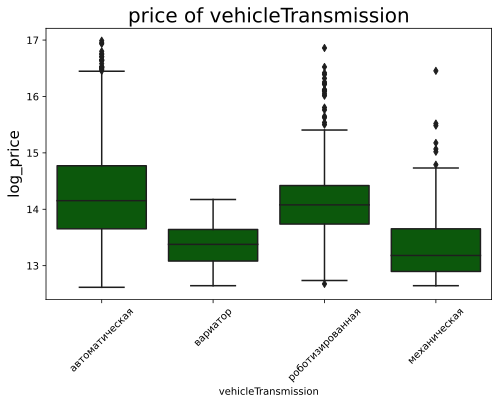

In [84]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='vehicleTransmission', 
                  data=train, color='darkgreen')
g1.set_title("price of vehicleTransmission", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

самые дешвые машины на механике и вариаторе. автомат самые дорогие

## 19. Владельцы 

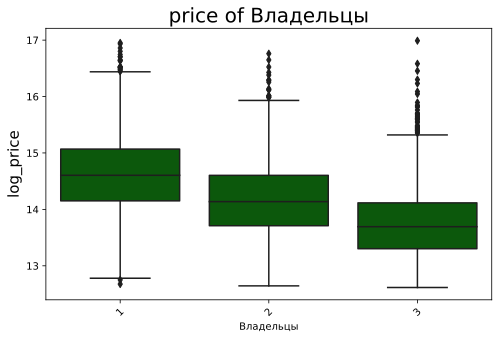

In [85]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='Владельцы', 
                  data=train, color='darkgreen')
g1.set_title("price of Владельцы", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

наблюдается тенденция на уменьшение стоимости с увеличением количества владельцев. Чем новее машина, тем меньше у нее владельцев

# PreProc Tabular Data

In [86]:
#Удалим ненужные признаки
columns_drop = ['Владение', 'name', 'Руль', 'vehicleConfiguration', 'bodyType',
    'log_power', 'Nalog_base']
train.drop(columns_drop, axis=1, inplace=True)
test.drop(columns_drop, axis=1, inplace=True)

Посмотрим корреляцию числовых признаков к целевой переменной

In [87]:
#используем
categorical_features = ['bodyType2', 'brand', 'color', 'color2', 
                        'fuelType', 'model_info','vehicleTransmission', 'Привод', 'age_intervals']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate', 'enginePower','Nalog', 'years_old', 'bT_length', 'engineDisplacement','price']

# бинарные
binary_features = ['ПТС']
rangovie = ['numberOfDoors', 'Владельцы']

In [88]:
correlation = train[numerical_features].corr()
correlation

,mileage,modelDate,productionDate,enginePower,Nalog,years_old,bT_length,engineDisplacement,price
mileage,1.000000,-0.679970,-0.710022,-0.186181,-0.143791,0.710022,-0.006596,0.050139,-0.538558
modelDate,-0.679970,1.000000,0.963949,0.101035,0.049249,-0.963949,0.040968,-0.195519,0.486031
productionDate,-0.710022,0.963949,1.000000,0.085113,0.030838,-1.000000,0.054170,-0.210013,0.512432
enginePower,-0.186181,0.101035,0.085113,1.000000,0.970987,-0.085113,0.082550,0.861285,0.491205
Nalog,-0.143791,0.049249,0.030838,0.970987,1.000000,-0.030838,0.076646,0.856927,0.426691
years_old,0.710022,-0.963949,-1.000000,-0.085113,-0.030838,1.000000,-0.054170,0.210013,-0.512432
bT_length,-0.006596,0.040968,0.054170,0.082550,0.076646,-0.054170,1.000000,0.112786,0.074805
engineDisplacement,0.050139,-0.195519,-0.210013,0.861285,0.856927,0.210013,0.112786,1.000000,0.289128
price,-0.538558,0.486031,0.512432,0.491205,0.426691,-0.512432,0.074805,0.289128,1.000000


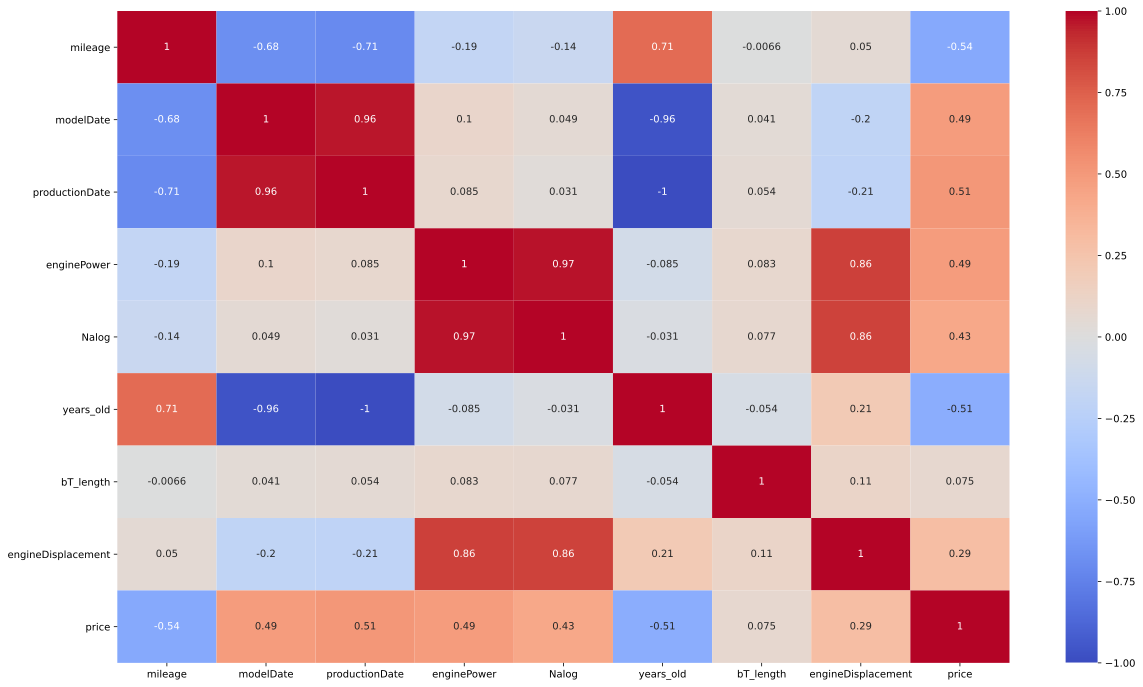

In [89]:
plt.figure(figsize=(20, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Стоимость автомобиля обратно коррелирует с возрастом машины и пробегом, и коррелирует с мощностью, объемом двигателя и налогом. 

Корреляция Спирмена для ранговых

In [90]:
train[['numberOfDoors', 'Владельцы']].corr(method='spearman')

,numberOfDoors,Владельцы
numberOfDoors,1.00000,-0.11562
Владельцы,-0.11562,1.00000


In [91]:
# Defining Student's test function.
def get_stat_dif(column):
    cols = train.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(train.loc[train.loc[:, column] == comb[0], 'price'], 
                        train.loc[train.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all):
            print('Statistically significant differences were found for the column', column)
            break

In [92]:
from itertools import combinations
from scipy.stats import ttest_ind

In [93]:
for col in categorical_features:
    get_stat_dif(col)

Statistically significant differences were found for the column bodyType2
Statistically significant differences were found for the column brand
Statistically significant differences were found for the column color
Statistically significant differences were found for the column color2
Statistically significant differences were found for the column fuelType
Statistically significant differences were found for the column model_info
Statistically significant differences were found for the column vehicleTransmission
Statistically significant differences were found for the column Привод
Statistically significant differences were found for the column age_intervals


columns = ['brand', 'color', 'description', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_info', 'numberOfDoors',
       'productionDate', 'vehicleTransmission',
       'Владельцы', 'ПТС', 'Привод', 'bodyType2', 'bT_length',
       'color2', 'Nalog', 'years_old', 'age_intervals', 'price']

columns1 = ['brand', 'color', 'description', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_info', 'numberOfDoors',
       'productionDate', 'vehicleTransmission',
       'Владельцы', 'ПТС', 'Привод', 'bodyType2', 'bT_length',
       'color2', 'Nalog', 'years_old', 'age_intervals']

df_train = train[columns]

df_test = test[columns1]

In [94]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 25) (1671, 23) (8353, 25)


In [95]:
from sklearn.preprocessing import LabelEncoder

In [96]:
#используем
categorical_features = ['bodyType2', 'brand', 'color2', 
                        'fuelType', 'model_info','numberOfDoors', 'vehicleTransmission', 'Привод', 'age_intervals', 'Владельцы']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate', 'enginePower','Nalog', 'years_old', 'bT_length', 'engineDisplacement','price']

# бинарные
binary_features = ['ПТС']

In [97]:
def preproc_data(df_input):
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id', 'color'], axis = 1, inplace=True)
    
    data['enginePower'] = np.log(data['enginePower'])
    data['mileage'] = np.log(data['mileage'])
    data['engineDisplacement'] = np.log(data['engineDisplacement']) 
    data['modelDate'] = np.log(2021 - data['modelDate'])

    # ################### Numerical Features ############################################################## 
    
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    label_encoder = LabelEncoder()
    for column in binary_features:
        df_output[column] = label_encoder.fit_transform(df_output[column])
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    #df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [98]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,ПТС,bT_length,Nalog,years_old,sample,...,vehicleTransmission_3,Привод_0,Привод_1,Привод_2,age_intervals_0,age_intervals_1,age_intervals_2,Владельцы_0,Владельцы_1,Владельцы_2
7399,0.220339,0.2720,0.106911,0.895833,0.868421,1,0.8125,0.167867,0.131579,1,...,0,0,0,1,1,0,0,1,0,0
4273,0.220339,0.2720,0.044904,0.875000,0.894737,1,0.8125,0.167867,0.105263,1,...,0,0,0,1,1,0,0,1,0,0
3362,0.813559,0.8160,0.054905,0.875000,0.868421,1,0.0625,0.834294,0.131579,1,...,0,0,0,1,1,0,0,0,0,1
2794,0.389831,0.2720,0.124912,0.833333,0.763158,1,0.0625,0.167867,0.236842,1,...,1,0,0,1,0,1,0,0,0,1
5378,0.220339,0.2288,0.148915,0.875000,0.868421,1,0.0625,0.127474,0.131579,1,...,0,0,0,1,1,0,0,0,0,1
5902,0.559322,0.7760,0.069707,0.854167,0.815789,1,0.6875,0.798271,0.184211,1,...,0,0,0,1,0,1,0,1,0,0
1454,0.389831,0.3920,0.052671,0.854167,0.868421,1,0.0625,0.452450,0.131579,0,...,0,0,0,1,1,0,0,0,1,0
2476,0.305085,0.2288,0.173417,0.750000,0.684211,0,0.0625,0.127474,0.315789,1,...,0,1,0,0,0,1,0,0,0,1
743,0.152542,0.0640,0.119912,0.750000,0.736842,1,0.5625,0.018972,0.263158,0,...,0,1,0,0,0,1,0,0,0,1
1168,0.813559,0.7504,0.035904,0.854167,0.842105,1,0.8125,0.775216,0.157895,0,...,0,0,0,1,0,1,0,0,0,1


In [99]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 169 entries, engineDisplacement to Владельцы_2
dtypes: float32(1), float64(9), int64(2), uint8(157)
memory usage: 2.0 MB


## Split data

In [100]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [101]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 168 entries, engineDisplacement to Владельцы_2
dtypes: float32(1), float64(9), int64(1), uint8(157)
memory usage: 406.3 KB


# Model 2: CatBoostRegressor

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [103]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.0503768	test: 0.0497008	best: 0.0497008 (0)	total: 57.9ms	remaining: 4m 49s
100:	learn: 0.0063887	test: 0.0058363	best: 0.0058363 (100)	total: 425ms	remaining: 20.6s
200:	learn: 0.0026283	test: 0.0026763	best: 0.0026763 (200)	total: 798ms	remaining: 19s
300:	learn: 0.0023190	test: 0.0024960	best: 0.0024918 (294)	total: 1.15s	remaining: 17.9s
400:	learn: 0.0019801	test: 0.0022164	best: 0.0022161 (398)	total: 1.51s	remaining: 17.3s
500:	learn: 0.0017543	test: 0.0020202	best: 0.0020202 (500)	total: 1.86s	remaining: 16.7s
600:	learn: 0.0015936	test: 0.0018991	best: 0.0018991 (600)	total: 2.22s	remaining: 16.2s
700:	learn: 0.0014358	test: 0.0017994	best: 0.0017992 (698)	total: 2.86s	remaining: 17.5s
800:	learn: 0.0013258	test: 0.0017340	best: 0.0017340 (800)	total: 3.37s	remaining: 17.7s
900:	learn: 0.0012264	test: 0.0016720	best: 0.0016720 (900)	total: 3.75s	remaining: 17.1s
1000:	learn: 0.0011513	test: 0.0016291	best: 0.0016291 (1000)	total: 4.23s

In [104]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 2.71%


### Submission

In [105]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

12.35 при исходной моделb 13.23 

# Model 3: Tabular NN

Построим обычную сеть:

In [106]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,ПТС,bT_length,Nalog,years_old,log_price,...,vehicleTransmission_3,Привод_0,Привод_1,Привод_2,age_intervals_0,age_intervals_1,age_intervals_2,Владельцы_0,Владельцы_1,Владельцы_2
7320,0.898305,0.7504,0.149915,0.770833,0.763158,1,0.0625,0.775216,0.236842,13.997832,...,0,1,0,0,0,1,0,1,0,0
8037,0.220339,0.2720,0.020844,0.937500,0.947368,1,0.8125,0.167867,0.052632,15.068274,...,0,0,0,1,1,0,0,1,0,0
4681,0.406780,0.2880,0.133810,0.687500,0.631579,1,0.0625,0.358790,0.368421,12.886641,...,0,0,0,1,0,0,1,0,0,1
6014,0.186441,0.1744,0.329933,0.729167,0.657895,1,0.0625,0.079731,0.342105,12.971540,...,0,1,0,0,0,0,1,0,0,1
3649,0.389831,0.3808,0.125913,0.833333,0.815789,1,0.0625,0.442363,0.184211,14.603968,...,0,0,0,1,0,1,0,1,0,0


## Simple Dense NN

In [107]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [108]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               86016     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 217,601
Trainable params: 217,601
Non-trainable params: 0
_________________________________________________________________


In [109]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [110]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [111]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

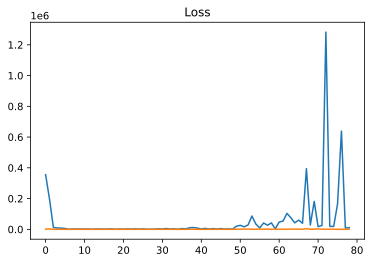

In [112]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [113]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [114]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 455.87%


In [115]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

11.66 при исходном 13.93

# Model 4: NLP + Multiple Inputs

In [116]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [117]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [118]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [119]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.97 s, sys: 1.77 ms, total: 1.97 s
Wall time: 1.98 s


In [120]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'у': 16,
 'пробегом': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'диски': 50,
 'кредит': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 '9': 63,
 'подогрев': 64,
 'заднего': 65,
 'состояние': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 '–': 71,
 'торг': 72,
 'дтп': 73,
 '

In [121]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.71 s, sys: 2.31 ms, total: 1.71 s
Wall time: 1.71 s


In [122]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

In [123]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [124]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [125]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [126]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [127]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [128]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [129]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 5s 441ms/step - loss: 20960.0527 - MAPE: 20960.0527 - val_loss: 172.7559 - val_MAPE: 172.7559
Epoch 2/500
12/12 [==============================] - 5s 406ms/step - loss: 4321.3008 - MAPE: 4321.3008 - val_loss: 137.8515 - val_MAPE: 137.8515
Epoch 3/500
12/12 [==============================] - 4s 357ms/step - loss: 7969.5532 - MAPE: 7969.5532 - val_loss: 146.9688 - val_MAPE: 146.9688
Epoch 4/500
12/12 [==============================] - 5s 378ms/step - loss: 2686.3342 - MAPE: 2686.3342 - val_loss: 141.4110 - val_MAPE: 141.4110
Epoch 5/500
12/12 [==============================] - 5s 379ms/step - loss: 1641.9607 - MAPE: 1641.9607 - val_loss: 93.7807 - val_MAPE: 93.7807
Epoch 6/500
12/12 [==============================] - 5s 376ms/step - loss: 1822.9900 - MAPE: 1822.9900 - val_loss: 114.2280 - val_MAPE: 114.2280
Epoch 7/500
12/12 [==============================] - 5s 388ms/step - loss: 2187.8948 - MAPE: 2187.8948 - val_loss: 93.8057 - val_M

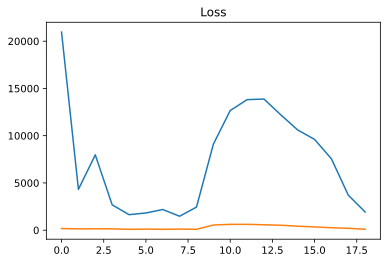

In [130]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [131]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [132]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 100.00%


In [133]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

11.73 при исходном 14.40

# Model 5: Добавляем картинки

### Data

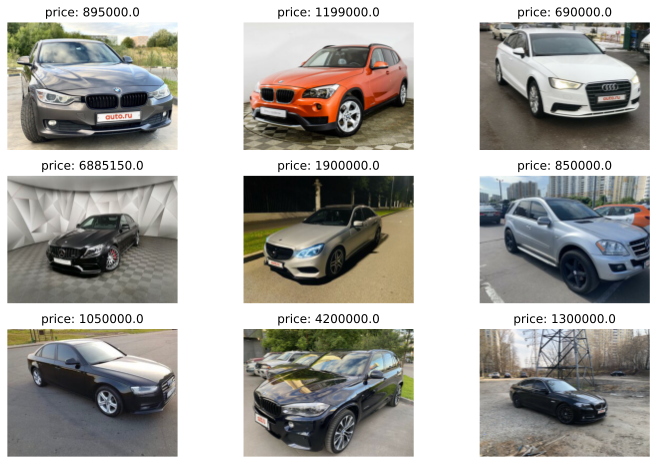

In [134]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [135]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

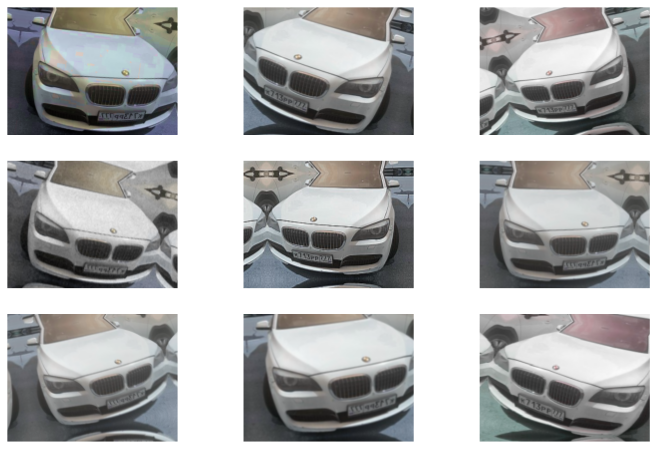

In [136]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [137]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [138]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [139]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [140]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [141]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [142]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [143]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [144]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [145]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [146]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 150s 792ms/step - loss: 1971.2701 - MAPE: 1971.2701 - val_loss: 820.7719 - val_MAPE: 820.7719
Epoch 2/100
190/190 [==============================] - 149s 784ms/step - loss: 3262.1140 - MAPE: 3262.1145 - val_loss: 878.2212 - val_MAPE: 878.2212
Epoch 3/100
190/190 [==============================] - 148s 780ms/step - loss: 20429.7285 - MAPE: 20429.7285 - val_loss: 428.4078 - val_MAPE: 428.4078
Epoch 4/100
190/190 [==============================] - 149s 786ms/step - loss: 8374.0674 - MAPE: 8374.0674 - val_loss: 123.9230 - val_MAPE: 123.9230
Epoch 5/100
190/190 [==============================] - 148s 777ms/step - loss: 3419.6123 - MAPE: 3419.6123 - val_loss: 414.1358 - val_MAPE: 414.1358
Epoch 6/100
190/190 [==============================] - 148s 779ms/step - loss: 8160.4536 - MAPE: 8160.4536 - val_loss: 130.1570 - val_MAPE: 130.1570
Epoch 7/100
190/190 [==============================] - 150s 790ms/step - loss: 3710.0901 - MAPE: 3710.09

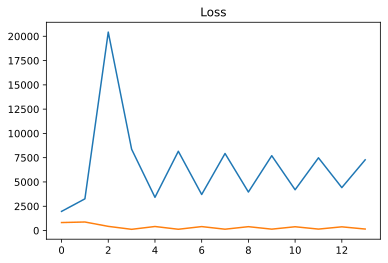

In [147]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [148]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [149]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 152.42%


In [150]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [151]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 76.92%


In [152]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [153]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [154]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [155]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [156]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 167)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          86016       dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [157]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [158]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 24ms/step - loss: 1120444.7500 - MAPE: 1120444.7500 - val_loss: 195.0235 - val_MAPE: 195.0235
Epoch 2/500
12/12 [==============================] - 0s 9ms/step - loss: 8015.9048 - MAPE: 8015.9048 - val_loss: 93.5012 - val_MAPE: 93.5012
Epoch 3/500
12/12 [==============================] - 0s 9ms/step - loss: 9800.9307 - MAPE: 9800.9307 - val_loss: 189.3671 - val_MAPE: 189.3671
Epoch 4/500
12/12 [==============================] - 0s 8ms/step - loss: 1433.4824 - MAPE: 1433.4824 - val_loss: 103.9513 - val_MAPE: 103.9513
Epoch 5/500
12/12 [==============================] - 0s 9ms/step - loss: 2720.9231 - MAPE: 2720.9231 - val_loss: 92.2451 - val_MAPE: 92.2451
Epoch 6/500
12/12 [==============================] - 0s 15ms/step - loss: 804.3096 - MAPE: 804.3096 - val_loss: 94.9752 - val_MAPE: 94.9752
Epoch 7/500
12/12 [==============================] - 0s 13ms/step - loss: 2386.1379 - MAPE: 2386.1379 - val_loss: 92.8370 - val_MAPE: 92.8370


In [159]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 245.60%


In [160]:
# 